**Project Description**:

The goal of this project is to predict house price based on real estate features extracted for houses in Bengaluru. The major sequence of steps in the coding process are listed below:

1.   Load and clean up the data.
2.   Analyze the features (*ordinal, categorical*, and *continuous*) for missingness, correct data type association, and distribution.
3.   Spit the data into train and test sets..
4.   Build an ML pipeline (*encoder -> imputer -> regression module*) for the train set by specifying seperate encoding and imputing steps (if needed) for ordinal, categorical, and continuous features.
5.   Train the ML pipeline on the train set and apply it for prediction on the test set.
6.   Report performance metrics

---

Import libraries

---

In [23]:
import pandas as pd
import numpy as np
import os
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('dark_background')
%matplotlib inline

## Pipeline module
from sklearn.pipeline import Pipeline

## Scaling, encoding, and imputation libraries
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

# Column trandformation library
from sklearn.compose import ColumnTransformer

## Train-test, cross-validation, and grid search modules
from sklearn.model_selection import train_test_split

## Cross-validation and grid search modules
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score

## Regression modules
from sklearn import linear_model

## Performance metrics modules
from sklearn.metrics import mean_squared_error, r2_score

---

Mount Google Drive if running in Colab

---

In [24]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/EvenSem2024MAHE'
    DATA_DIR = DIR + '/Data/'
    os.chdir(DIR)
else:
    DATA_DIR = 'Data/'

---

Load bengaluru house price data

---

In [25]:
## Load Bengaluru house price data
file = DATA_DIR+'houseprices.csv'
df= pd.read_csv(file, header = 0)

print('Bengaluru house price dataset')
print('-----------')
print('Initial number of samples = %d'%(df.shape[0]))
print('Initial number of features = %d\n'%(df.shape[1]))
df.head(5)

Bengaluru house price dataset
-----------
Initial number of samples = 225
Initial number of features = 9



,locality,title,area,rent,price_per_sqft,facing,BHK,bathrooms,parking
0,BTM Layout,"1 BHK Apartment For Sale In Sandy Villa, Btm...",565 sqft,"20,060/Month","₹6,195 per sq.ft.",North-West,1 BHK,1,Bike
1,BTM Layout,3 BHK Apartment For Sale In Sobha Magnolia I...,"1,837 sqft","97,434/Month","₹9,254 per sq.ft.",East,3 BHK,3,Bike and Car
2,BTM Layout,2 BHK Flat For Sale In Nandi Jewels In Btm 2...,"1,280 sqft","54,448/Month","₹7,422 per sq.ft.",East,2 BHK,2,Car
3,BTM Layout,3 BHK Apartment For Sale In Brigade Lakeview...,"2,220 sqft",1.17 Lacs/Month,"₹9,234 per sq.ft.",North,3 BHK,3,Bike and Car
4,BTM Layout,2 BHK Apartment For Sale In Niranjan Central...,"1,113 sqft","34,388/Month","₹5,391 per sq.ft.",East,2 BHK,2,Bike and Car


---

Clean up data

----

In [27]:
## Clean up data
# Remove 'title' column
#df.drop('title', axis = 1, inplace = True)

# Retain only numerical values in area column
df['area'] = df['area'].apply(lambda x: float(x.split(' ')[0].replace(',', '')) if isinstance(x, str) else x)

# Retain only numerical values in rent column
def rent_column_modify(val):
  if isinstance(val, str):
    if 'Lacs' in val:
      return(float(val.split(' ')[0].split('/')[0].replace(',', ''))*1e5)
    else:
      return(float(val.split('/')[0].replace(',', '')))
  else:
    return val
df['rent'] = df['rent'].apply(rent_column_modify)

# Retain only numerical values in the price_per_sqft column
df['price_per_sqft'] = df['price_per_sqft'].apply(lambda x: float(x.replace('₹', '').split(' ')[0].replace(',', '')) if isinstance(x, str) else x)

# Retain only numerical values in BHK columns
df['BHK'] = df['BHK'].apply(lambda x: int(x.split(' ')[0].replace('+', '')))

# Change 'Don't Know' entries in 'facing' column to NaN
df['facing'] = df['facing'].apply(lambda x: x if x != "Don't Know" else np.nan)

# Change 'None' entries in 'parking' column to Nan
df['parking'] = df['parking'].apply(lambda x: np.nan if x == 'None' else x)



KeyError: "['title'] not found in axis"

In [28]:
df.columns

Index(['locality', 'area', 'rent', 'price_per_sqft', 'facing', 'BHK',
       'bathrooms', 'parking'],
      dtype='object')

---

Plot percentage of missing values (NaNs) for each feature

---

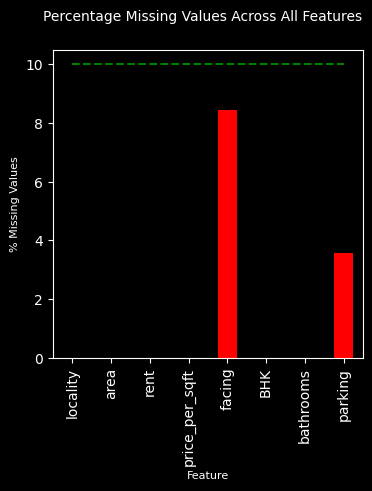

In [29]:
## Plot percentage of missing values (NaNs) for each feature
cutoff = 10 # we will remove features missing in more than cutoff% of the samples
fig = plt.figure(figsize=(4, 4))
percent_missing = (df.isnull().sum() / df.shape[0]) * 100
percent_missing.plot(kind = 'bar', color = cm.rainbow(np.linspace(0, 1, 2))[(percent_missing <= cutoff).values.astype(int)])
plt.plot(np.arange(df.shape[1]), np.repeat(cutoff, df.shape[1]), 'g--')
fig.suptitle('Percentage Missing Values Across All Features', fontsize = 10)
plt.xlabel('Feature', fontsize = 8)
plt.ylabel('% Missing Values', fontsize = 8);

---

Create lists of ordinal, categorical, and continuous features

---

In [30]:
## Create lists of ordinal, categorical, and continuous features
ordinal_features = ['BHK', 'bathrooms']
categorical_features = ['locality', 'facing', 'parking']
continuous_features = (df.drop(ordinal_features, axis = 1)).drop(categorical_features, axis = 1).columns.tolist()

---

Assign 'category' datatype to ordinal and categorical columns

---

In [31]:
## Assign 'category' datatype to ordinal and categorical columns
print(df.dtypes)
df[ordinal_features + categorical_features] = df[ordinal_features + categorical_features].astype('category')
print('----')
df.dtypes

locality           object
area              float64
rent              float64
price_per_sqft    float64
facing             object
BHK                 int64
bathrooms           int64
parking            object
dtype: object
----


locality          category
area               float64
rent               float64
price_per_sqft     float64
facing            category
BHK               category
bathrooms         category
parking           category
dtype: object

---

Print unique values in each ordinal and categorical features

---

In [32]:
## Print unique values in each ordinal and categorical features
print(df[ordinal_features + categorical_features].nunique())
print('\nUnique values in ordinal and categorical features')
print('---------------------------------------------------')
unique_values = {col:list(df[col].unique()) for col in ordinal_features + categorical_features}
for key, value in unique_values.items():
  print(key, value)

BHK           4
bathrooms    10
locality      9
facing        7
parking       3
dtype: int64

Unique values in ordinal and categorical features
---------------------------------------------------
BHK [1, 3, 2, 4]
bathrooms [1, 3, 2, 5, 13, 4, 26, 16, 6, 14]
locality ['BTM Layout', 'Attibele', 'K R Puram ', 'Marathahalli', 'Indiranagar', 'Electronic City', 'Yalahanka', 'Malleshwaram', 'Jayanagar']
facing ['North-West', 'East', 'North', 'West', 'North-East', 'South-East', 'South', nan]
parking ['Bike', 'Bike and Car', 'Car', nan]


---

Remove the target variable column from the list of continuous features

---

In [33]:
## Remove the target variable column from the list of continuous features
continuous_features.remove('rent')

---

Plot the distributions of the features

---

---

Train-test split of the dataset

---

In [34]:
## Train and test split of the data
X = df.drop('rent', axis = 1)
y = df['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,
                                                    random_state = 1)
print('# training samples = %d, # test samples = %d'%(X_train.shape[0], X_test.shape[0]))

# training samples = 202, # test samples = 23


---

Build pipeline for ordinal, categorical, and continuous features

---

In [ ]:
## Build pipeline for ordinal, categorical, and continuous features

# Pipeline object for ordinal features
ordinal_transformer = Pipeline(steps = [('ordinalenc', OrdinalEncoder())])

# Pipeline object for categorical (features
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(missing_values = ?, strategy = ?)), ('onehotenc', ?(handle_unknown = 'ignore'))])

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps = [('scaler', ?)])

# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers = [('continuous', continuous_transformer, continuous_features),
                                                 ('categorical', categorical_transformer, categorical_features),
                                                 ('ordinal', ordinal_transformer, ordinal_features)
                                                ],
                                 remainder = 'passthrough'
                                 )

# Define a classifier object
regressor = linear_model.LinearRegression()

# Define the entire classification model pipeline
model_pipeline = Pipeline(steps = [('preprocessor', ?), ('regressor', ?)])

In [35]:
# Pipeline object for ordinal features
ordinal_transformer = Pipeline(steps=[('ordinalenc', OrdinalEncoder())])

# Pipeline object for categorical features
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehotenc', OneHotEncoder(handle_unknown='ignore'))])

# Pipeline object for continuous features
continuous_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor object for all features
preprocessor = ColumnTransformer(transformers=[('continuous', continuous_transformer, continuous_features),
                                               ('categorical', categorical_transformer, categorical_features),
                                               ('ordinal', ordinal_transformer, ordinal_features)],
                                 remainder='passthrough')

# Define a classifier object
regressor = linear_model.LinearRegression()

# Define the entire classification model pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)])

In [36]:
X_train.columns

Index(['locality', 'area', 'price_per_sqft', 'facing', 'BHK', 'bathrooms',
       'parking'],
      dtype='object')

In [37]:
X_test.columns

Index(['locality', 'area', 'price_per_sqft', 'facing', 'BHK', 'bathrooms',
       'parking'],
      dtype='object')

---

Fit the pipeline on the train data and test on the test data

---

In [39]:
## Fit the model pipeline on the train data and test on the test data
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)
print('Mean Squared Error : {}'.format(mean_squared_error(y_test, y_pred)))
print("Root mean squared error: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print('r2_score : {}'.format(r2_score(y_test, y_pred)))

Mean Squared Error : 202764566.1235892
Root mean squared error: 14239.542342490828
r2_score : 0.8243890501909235


In [40]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
39,31522.0,39237.828358,-7715.828358
166,72658.0,96350.120729,-23692.120729
93,31522.0,12449.653508,19072.346492
62,35735.0,36014.045016,-279.045016
195,66484.0,74259.090502,-7775.090502
119,115000.0,105659.255241,9340.744759
38,20633.0,19523.802011,1109.197989
184,85971.0,119016.275510,-33045.275510
160,10316.0,-5375.155054,15691.155054
89,28657.0,8033.398055,20623.601945
